# Import Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools
import warnings
warnings.filterwarnings('ignore')
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import numpy as np
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [3]:
# 导入数据
df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/微众实习/Shibor_LPR_国债相关利率数据.xlsx')
df.set_index('日期', inplace=True)

# 删除'市场询价利率(6M)'缺失值
df.dropna(subset=['市场询价利率(6M)'], inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1210 entries, 2018-06-11 to 2023-04-27
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   O/N         1210 non-null   float64
 1   1W          1210 non-null   float64
 2   2W          1210 non-null   float64
 3   1M          1210 non-null   float64
 4   3M          1210 non-null   float64
 5   6M          1210 non-null   float64
 6   9M          1210 non-null   float64
 7   1Y          1210 non-null   float64
 8   LPR(1Y)     1210 non-null   float64
 9   1年期国债收益率    1210 non-null   float64
 10  10年期国债收益率   1210 non-null   float64
 11  市场询价利率(6M)  1210 non-null   float64
dtypes: float64(12)
memory usage: 122.9 KB
None


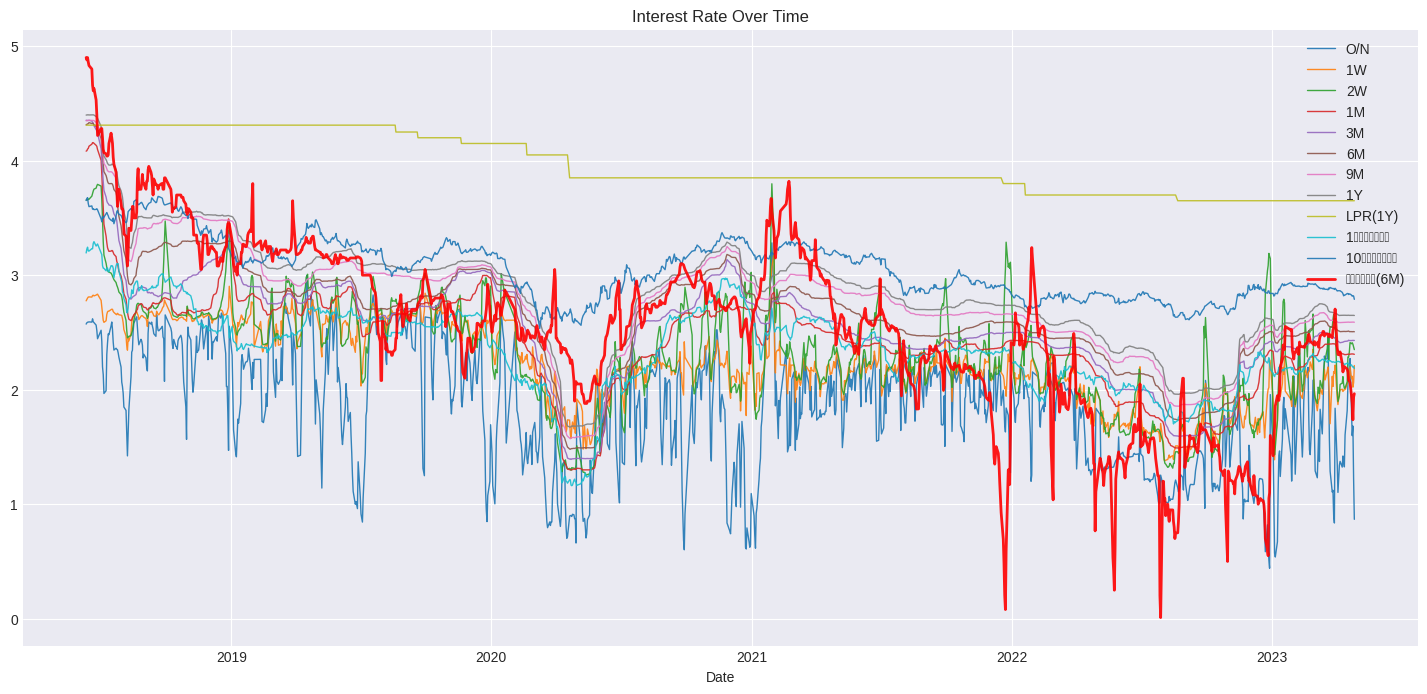

In [ ]:
import matplotlib.pyplot as plt

# 数据可视化（label）
label_column = '市场询价利率(6M)'
plt.figure(figsize=(18, 8))

# Plot each column, but skip the '市场询价利率(6M)' column for now
for column in df.columns:
    if column != label_column:
        plt.plot(df.index, df[column], label=column, linewidth=1, alpha=0.9)

# Now plot the '市场询价利率(6M)' column with a different style to highlight it
plt.plot(df.index, df[label_column], color='red', linewidth=2, alpha=0.9, label=label_column)

plt.xlabel('Date')
# plt.ylabel('Interest Rate')
plt.title('Interest Rate Over Time')
plt.legend(loc='upper right')
plt.show()


# Original Data


## Data Visualization

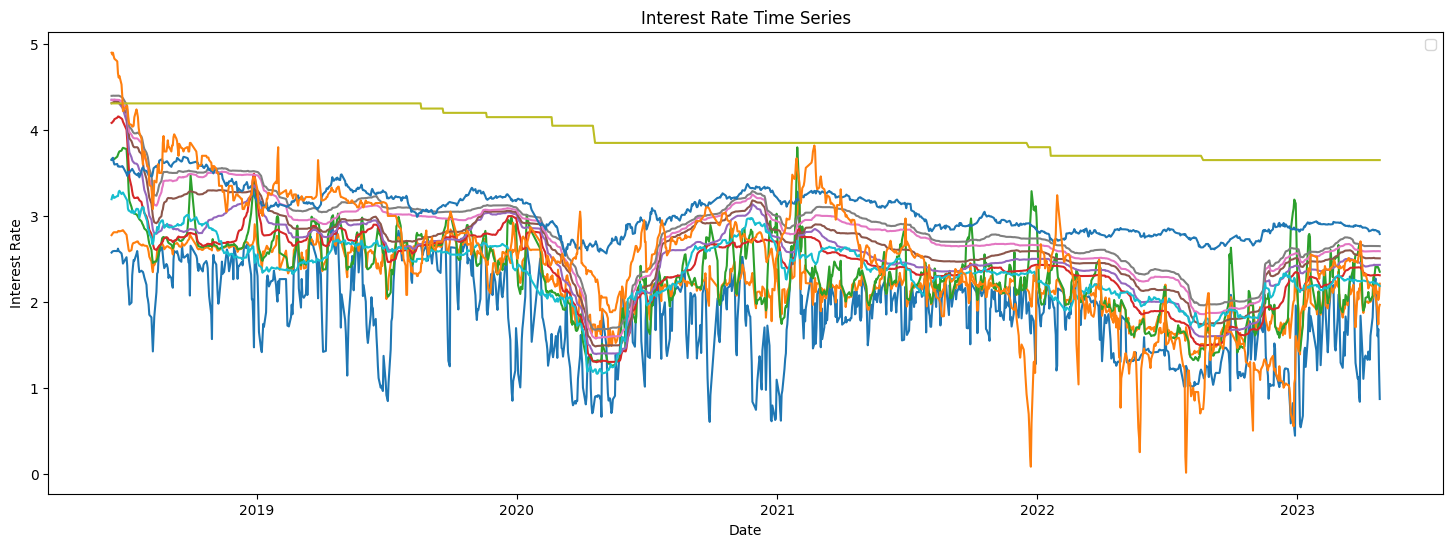

               O/N           1W           2W           1M          3M  \
count  1210.000000  1210.000000  1210.000000  1210.000000  1210.00000   
mean      1.850521     2.220382     2.308202     2.414709     2.53457   
std       0.524494     0.351247     0.473129     0.452492     0.47433   
min       0.441000     1.381000     1.253000     1.300000     1.39100   
25%       1.432250     2.006250     2.017750     2.264750     2.35925   
50%       1.908500     2.198500     2.319500     2.417000     2.55050   
75%       2.220000     2.579000     2.650750     2.703750     2.83000   
max       3.282000     3.194000     3.798000     4.157000     4.35300   

                6M           9M           1Y      LPR(1Y)     1年期国债收益率  \
count  1210.000000  1210.000000  1210.000000  1210.000000  1210.000000   
mean      2.650394     2.771269     2.845777     3.955504     2.348247   
std       0.477977     0.487882     0.481863     0.248594     0.373235   
min       1.480000     1.572000     1.674000  

In [ ]:
# 数据可视化（label）
label_column = df.columns[-1]
plt.figure(figsize=(18, 6))
plt.plot(df.index, df)
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.title('Interest Rate Time Series')
plt.legend()
plt.show()

# Summary Statistics
summary_stats = df.describe()
print(summary_stats)

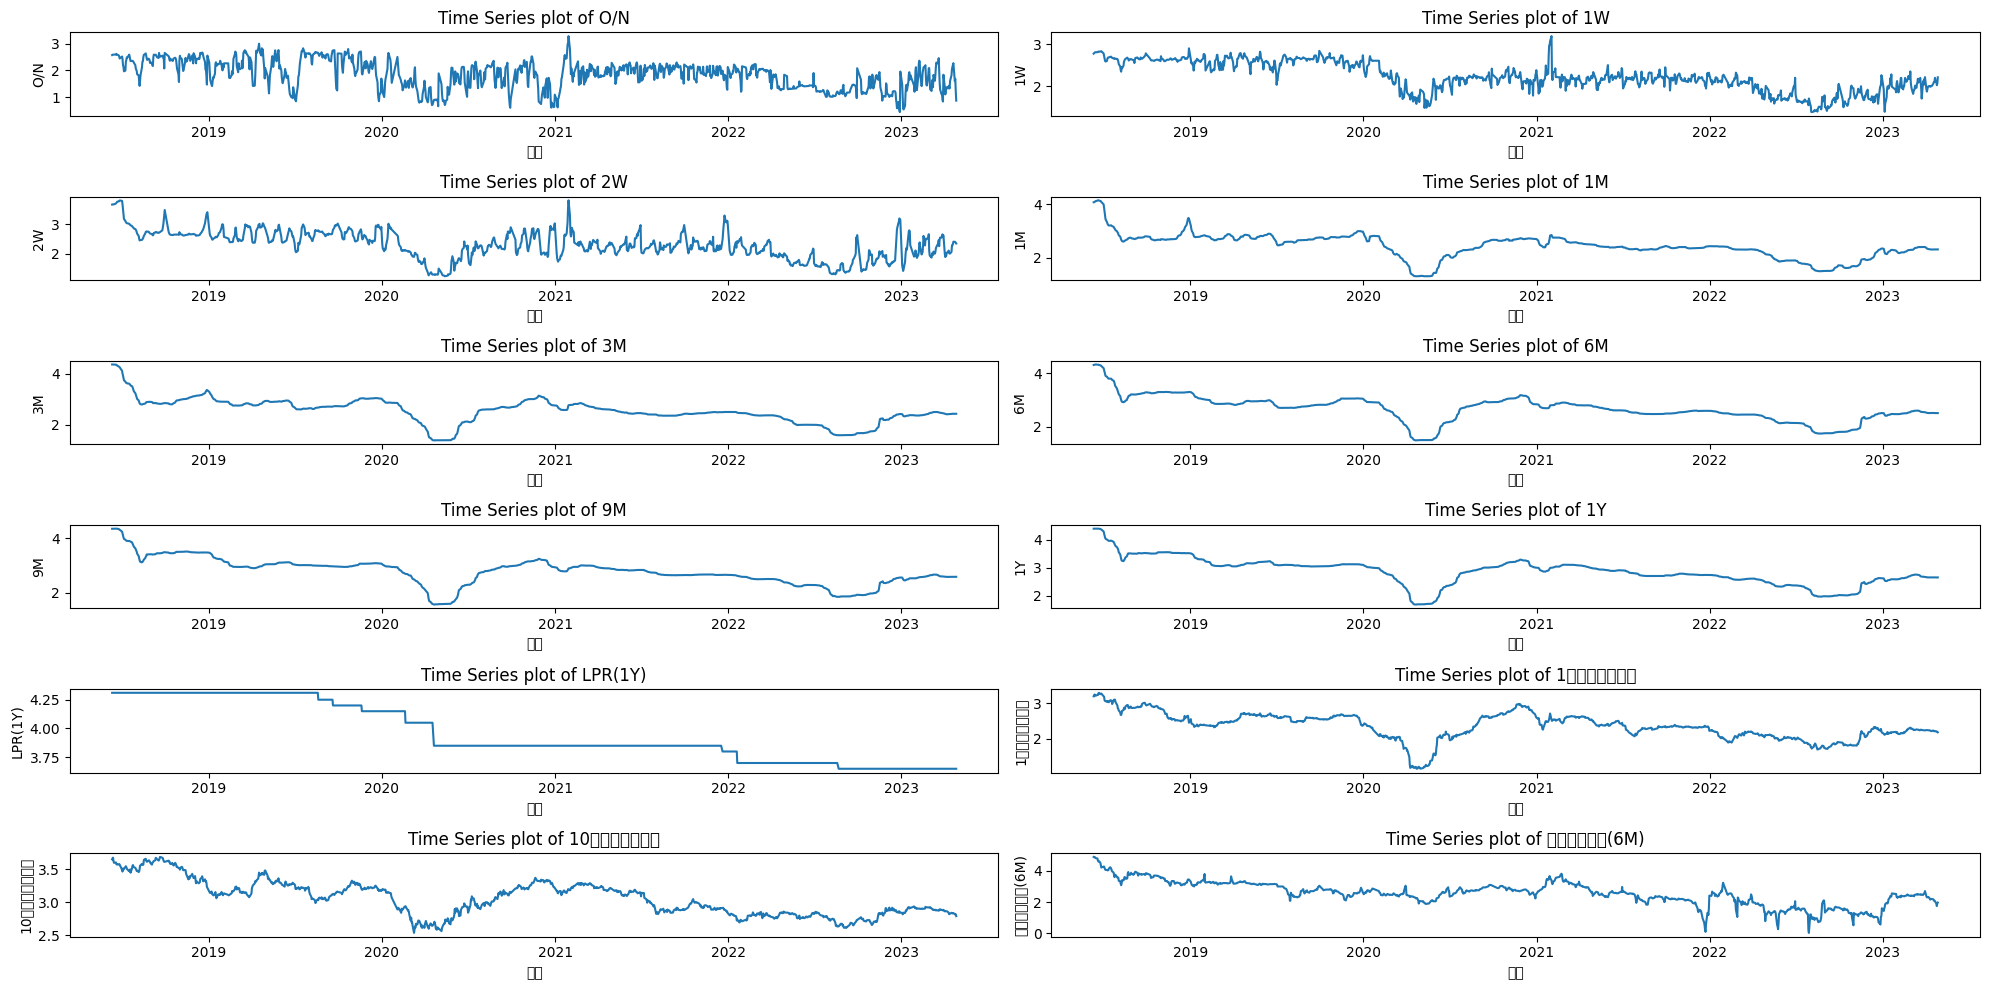

In [ ]:
# Plotting
fig, axes = plt.subplots(6, 2, figsize=(20,10))
axes = axes.ravel()  # Flattens the axis array

for i, column in enumerate(df.columns):
    # Check if the column is numeric for plotting
    if pd.api.types.is_numeric_dtype(df[column]):
        axes[i].plot(df.index, df[column])
        axes[i].set_title(f"Time Series plot of {column}")
        axes[i].set_xlabel('日期')
        axes[i].set_ylabel(column)

plt.tight_layout()
plt.show()

### Exploratory Analysis


##### ACF & PACF Plot

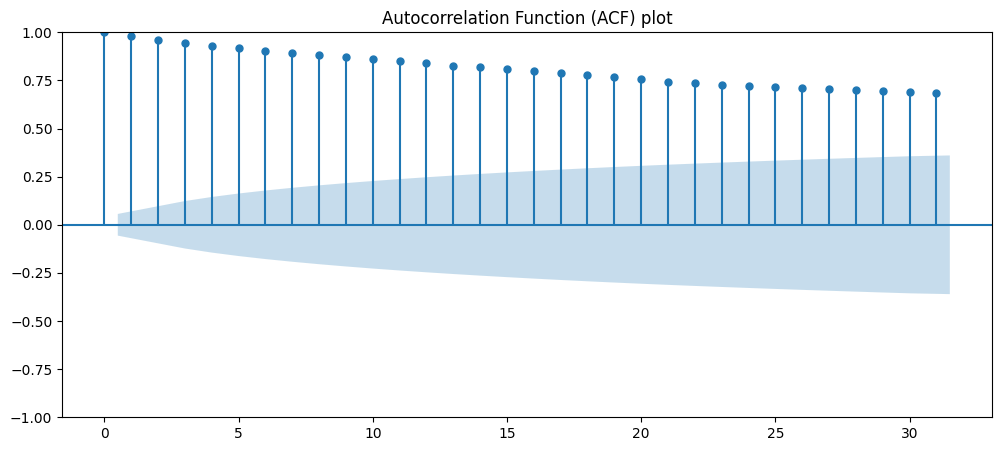

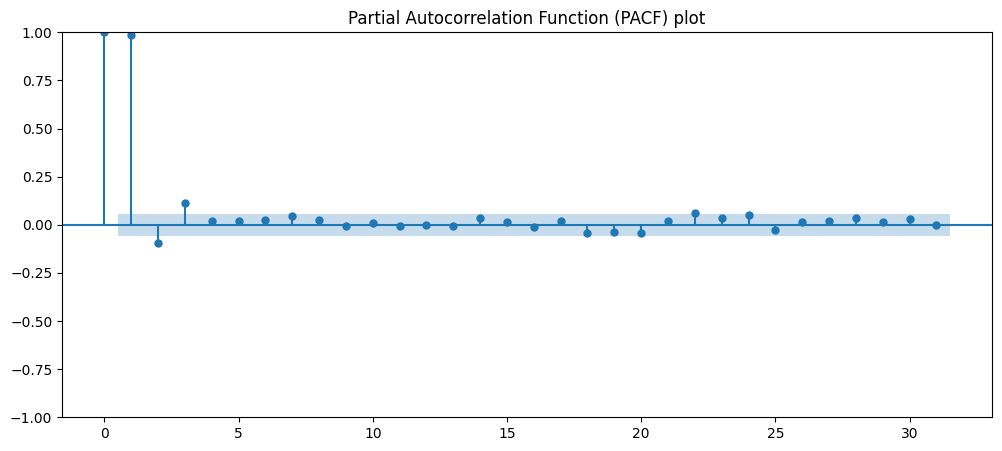

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF
plt.figure(figsize=(12, 5))
plot_acf(df['市场询价利率(6M)'], ax=plt.gca())
plt.title('Autocorrelation Function (ACF) plot')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 5))
plot_pacf(df['市场询价利率(6M)'], ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) plot')
plt.show()

考虑lag = 3？

##### Augmented Dickey-Fuller test

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['市场询价利率(6M)'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.559379
p-value: 0.006587
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


This suggests that the time series is stationary, meaning it does not have a trend or seasonality that varies with time.

p值（0.006587）小于显著性水平0.05（5%）。这进一步支持了拒绝零假设的结论，确认了时间序列的平稳性。

##### White Noise

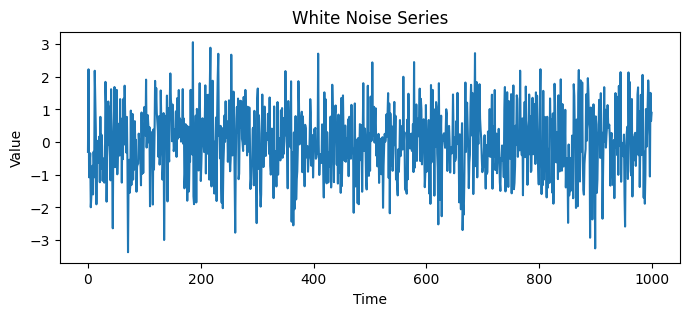

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_samples = 1000  # Number of samples in the series
mean = 0  # Mean of the white noise
std_dev = 1  # Standard deviation of the white noise

# Generate white noise series
white_noise_series = np.random.normal(mean, std_dev, n_samples)

# Plot the series
plt.figure(figsize=(8, 3))
plt.plot(white_noise_series)
plt.title('White Noise Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


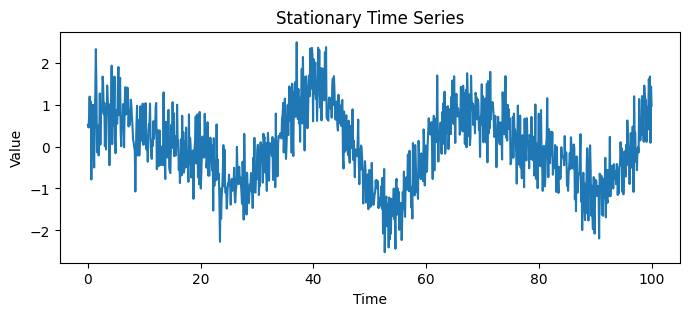

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_samples = 1000
time = np.linspace(0, 100, n_samples)

# Create a sinusoidal pattern (stationary)
sinusoidal_pattern = np.sin(0.2 * time) + 0.5 * np.cos(0.3 * time)

# Generate white noise
mean = 0
std_dev = 0.5
white_noise = np.random.normal(mean, std_dev, n_samples)

# Create a stationary time series by adding the sinusoidal pattern and white noise
stationary_series = sinusoidal_pattern + white_noise

# Plot the series
plt.figure(figsize=(8, 3))
plt.plot(time, stationary_series)
plt.title('Stationary Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


### Model

In [4]:
# 删除缺失值
df = df.dropna()

# 用'市场询价利率(6M)'列作时间序列
ts = df['市场询价利率(6M)']

# Splitting the data into train and test sets
size = int(len(ts) * 0.7) # 70% for training
train, test = ts[0:size], ts[size:len(ts)]

#### AR(3) Model

In [5]:
# Autoregressive Model (AR)
ar_model = AutoReg(train, lags=3)
ar_model_fit = ar_model.fit()
# AR Predict
ar_forecast = ar_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# AR Evaluation
ar_rmse = sqrt(mean_squared_error(test, ar_forecast))
print(f'Test RMSE for AR model: {ar_rmse:.4f}')

Test RMSE for AR model: 1.0940


In [6]:
# Getting the in-sample predictions
ar_train_predictions = ar_model_fit.fittedvalues

In [7]:
# AR Evaluation on train set (excluding the initial points corresponding to the number of lags)
ar_train_rmse = sqrt(mean_squared_error(train[3:], ar_train_predictions))
print(f'Train RMSE for AR model: {ar_train_rmse:.4f}')

Train RMSE for AR model: 0.0773


#### MA Model

In [ ]:
# Define the range of q values to test
q_values = range(0, 30)

best_rmse = float('inf')
best_q = None

for q in q_values:
    try:
        # Fit an MA model with order (0, 0, q)
        model = ARIMA(train, order=(0, 0, q))
        results = model.fit()
        predictions = results.predict(start=len(train), end=len(train)+len(test)-1)
        rmse = mean_squared_error(test, predictions, squared=False)
        if rmse < best_rmse:
            best_rmse = rmse
            best_q = q
    except:
        continue

print('Best RMSE:', best_rmse)
print('Best q:', best_q)

The MA model with q = 0 is reduced to a white noise process, meaning that it's essentially modeling random noise.

MA模型q值=0，被简化为白噪声

In [8]:
# Moving Average Model (MA)
ma_model = ARIMA(train, order=(0, 0, 2)) # p=0, d=0, q=1 for MA model
ma_model_fit = ma_model.fit()

# MA Predict
ma_forecast = ma_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# MA Evaluation
ma_rmse = sqrt(mean_squared_error(test, ma_forecast))
print(f'Test RMSE for MA model: {ma_rmse:.4f}')


Test RMSE for MA model: 1.2987


In [9]:
# Getting the in-sample predictions
ma_train_predictions = ma_model_fit.fittedvalues

In [10]:
# AR Evaluation on train set (excluding the initial points corresponding to the number of lags)
ma_train_rmse = sqrt(mean_squared_error(train, ma_train_predictions))
print(f'Train RMSE for MA model: {ma_train_rmse:.4f}')

Train RMSE for MA model: 0.2036


#### ARIMA Model

Grid search for p and q

In [ ]:
import itertools
# Define the p, d and q ranges
p = q = range(0, 10)
d = [0]
# Record the best RMSE
best_rmse = float('inf')
best_order = None

# Iterate through all combinations
for param in itertools.product(p, d, q):
    try:
        # Fit the ARIMA model
        model = ARIMA(train, order=param)
        results = model.fit()

        # Make predictions
        predictions = results.predict(start=len(train), end=len(train)+len(test)-1)

        # Calculate the RMSE
        rmse = mean_squared_error(test, predictions, squared=False)

        # Update the best RMSE and parameters
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = param
    except:
        continue

print('Best RMSE:', best_rmse)
print('Best Order:', best_order)


In [11]:
# ARIMA Model
arima_model = ARIMA(train, order=(6, 0, 8)) # p=6, d=0, q=8 for ARIMA model
arima_model_fit = arima_model.fit()

# ARIMA Predict
arima_forecast = arima_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# ARIMA Evaluation
arima_rmse = sqrt(mean_squared_error(test, arima_forecast))
print(f'Test RMSE for MA model: {arima_rmse:.4f}')


Test RMSE for MA model: 0.7362


In [12]:
# Getting the in-sample predictions
arima_train_predictions = arima_model_fit.fittedvalues
# AR Evaluation on train set (excluding the initial points corresponding to the number of lags)
arima_train_rmse = sqrt(mean_squared_error(train, arima_train_predictions))
print(f'Train RMSE for ARIMA model: {arima_train_rmse:.4f}')

Train RMSE for ARIMA model: 0.0970


#### ETS

In [13]:
ets_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
ets_model_fit = ets_model.fit()
ets_forecast = ets_model_fit.predict(start=len(train), end=len(train)+len(test)-1)
ets_rmse = sqrt(mean_squared_error(test, ets_forecast))
print(f'Test RMSE for ETS model:, {ets_rmse:.4f}')

Test RMSE for ETS model:, 0.7188


In [14]:
# Getting the in-sample predictions
ets_train_predictions = ets_model_fit.fittedvalues
# AR Evaluation on train set (excluding the initial points corresponding to the number of lags)
ets_train_rmse = sqrt(mean_squared_error(train, ets_train_predictions))
print(f'Train RMSE for ETS model: {ets_train_rmse:.4f}')

Train RMSE for ETS model: 0.0791


#### Prophet

In [15]:
# Format the training data
train_df = train.reset_index()
train_df.columns = ['ds', 'y']

# Fit the model
prophet_model = Prophet()
prophet_model.fit(train_df)

# Format the test data
test_df = test.reset_index()
test_df.columns = ['ds', 'y']

# Create a future dataframe that includes the test dates
future = test_df.drop('y', axis=1)

# Make predictions
prophet_forecast = prophet_model.predict(future)

# Compute the RMSE
prophet_rmse = np.sqrt(mean_squared_error(test_df['y'], prophet_forecast['yhat']))
print(f'Test RMSE for prophet model:, {prophet_rmse:.4f}')

DEBUG:cmdstanpy:input tempfile: /tmp/tmpjx_b_ibv/_o_ev8cj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjx_b_ibv/ycg5ac__.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14418', 'data', 'file=/tmp/tmpjx_b_ibv/_o_ev8cj.json', 'init=/tmp/tmpjx_b_ibv/ycg5ac__.json', 'output', 'file=/tmp/tmpjx_b_ibv/prophet_model6yu6tcql/prophet_model-20230907023639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:36:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:36:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test RMSE for prophet model:, 0.8836


In [16]:
# Create a future dataframe that includes the training dates
train_future = train_df.drop('y', axis=1)

# Make predictions on the training data
prophet_train_forecast = prophet_model.predict(train_future)

# Compute the training RMSE
prophet_train_rmse = np.sqrt(mean_squared_error(train_df['y'], prophet_train_forecast['yhat']))
print(f'Train RMSE for Prophet model: {prophet_train_rmse:.4f}')


Train RMSE for Prophet model: 0.1570


### Models Performance

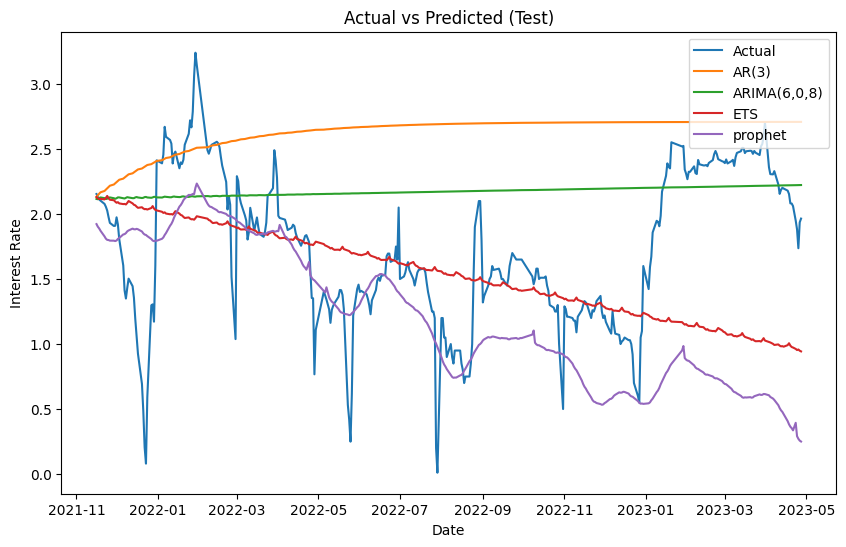

In [32]:
plt.figure(figsize=(10, 6))
# Plot the actual test values
plt.plot(test_df['ds'], test_df['y'], label='Actual')
# Plot the AR(3) predicted values
plt.plot(test_df['ds'], ar_forecast.values, label = 'AR(3)')
# Plot the AR(3) predicted values
plt.plot(test_df['ds'], arima_forecast.values, label = 'ARIMA(6,0,8)')
# Plot the ETS predicted values
plt.plot(test_df['ds'], ets_forecast.values, label = 'ETS')
# Plot the predicted values
plt.plot(test_df['ds'], prophet_forecast['yhat'], label='prophet')

plt.legend(loc = 'upper right')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.title('Actual vs Predicted (Test)')
plt.show()

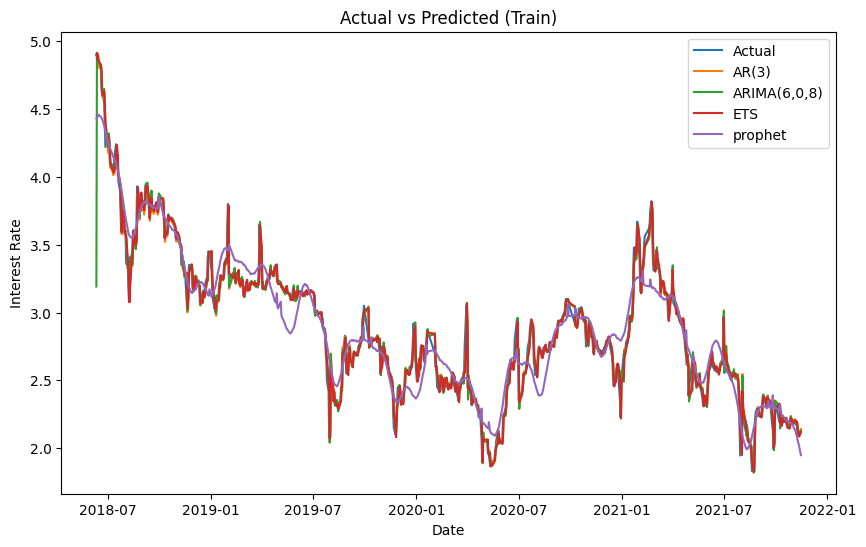

In [31]:
plt.figure(figsize=(10, 6))
# Plot the actual test values
plt.plot(train_df['ds'], train_df['y'], label='Actual')
# Plot the AR(3) predicted values
plt.plot(train_df['ds'][3:], ar_train_predictions.values, label = 'AR(3)')
# Plot the AR(3) predicted values
plt.plot(train_df['ds'], arima_train_predictions.values, label = 'ARIMA(6,0,8)')
# Plot the ETS predicted values
plt.plot(train_df['ds'], ets_train_predictions.values, label = 'ETS')
# Plot the predicted values
plt.plot(train_df['ds'], prophet_train_forecast['yhat'], label='prophet')

plt.legend(loc = 'upper right')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.title('Actual vs Predicted (Train)')
plt.show()

In [ ]:
model_names = ['AR_Original', 'MA_Original', 'ARIMA_Original', 'ETS_Original', 'Prophet_Original']
rmses = [ar_rmse, ma_rmse, arima_rmse, ets_rmse, prophet_rmse]

comparison_df = pd.DataFrame({'Model': model_names, 'RMSE': rmses})
print(comparison_df)


              Model      RMSE
0       AR_Original  1.094040
1       MA_Original  1.298721
2    ARIMA_Original  0.736179
3      ETS_Original  0.718850
4  Prophet_Original  0.883641


# Set Diff 一次差分

##### ACF & PACF Plots

In [37]:
# Differencing the series (replace 1 with the order of differencing you want)
diff_series = df['市场询价利率(6M)'].diff(periods=1).dropna()

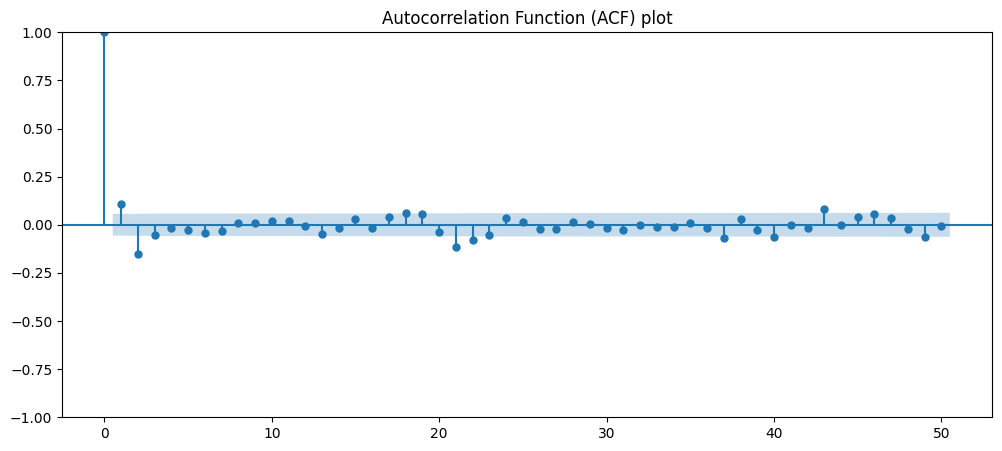

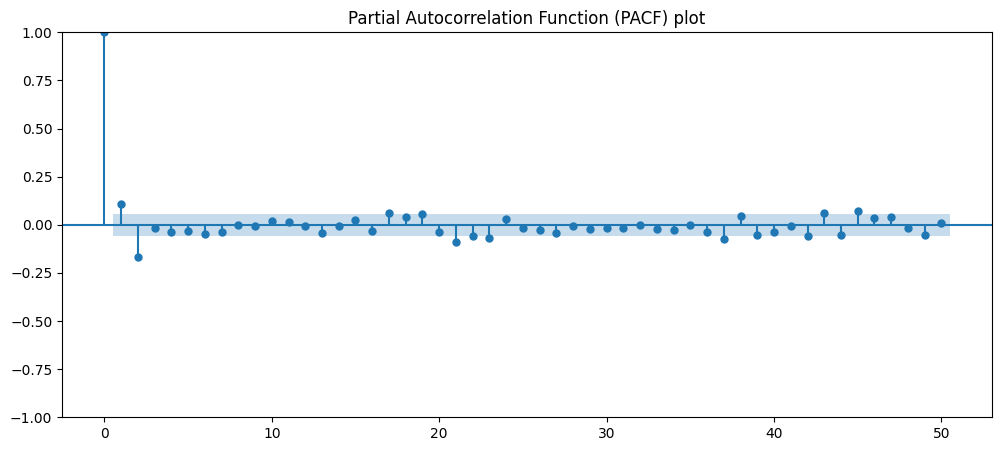

In [38]:
# Plot ACF
plt.figure(figsize=(12, 5))
plot_acf(diff_series, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) plot')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 5))
plot_pacf(diff_series, lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) plot')
plt.show()

In [39]:
diff_series.describe()

count    1209.000000
mean       -0.002428
std         0.124619
min        -1.000000
25%        -0.040000
50%         0.000000
75%         0.030000
max         1.253000
Name: 市场询价利率(6M), dtype: float64

### Model(Set Diff)

#### AR(2) Model

In [40]:
# Use the '市场询价利率(6M)' column for time series
ts = diff_series

# Splitting the data into train and test sets
size = int(len(ts) * 0.7) # 70% for training
train, test = ts[0:size], ts[size:len(ts)]

# Autoregressive Model (AR)
diff_ar_model = AutoReg(train, lags=2)
diff_ar_model_fit = diff_ar_model.fit()

# AR Predict
diff_ar_forecast = diff_ar_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# AR Evaluation
diff_ar_rmse = sqrt(mean_squared_error(test, diff_ar_forecast))
print(f'Test RMSE for AR(3) model: {diff_ar_rmse:.4f}')

Test RMSE for AR(3) model: 0.1920


In [43]:
# Getting the in-sample predictions
diff_ar_train_predictions = diff_ar_model_fit.fittedvalues

In [45]:
# AR Evaluation on training data
diff_ar_train_rmse = sqrt(mean_squared_error(train[2:], diff_ar_train_predictions))
print(f'Train RMSE for AR(2) differenced series model: {diff_ar_train_rmse:.6f}')


Train RMSE for AR(2) differenced series model: 0.077938


In [ ]:
# Assuming `original_series` is your original time series data
original_series = df['市场询价利率(6M)']

# Invert the differencing on the forecasts
inverted_ar_forecast = np.r_[original_series[size - 1], diff_ar_forecast].cumsum()

# Invert the differencing on the train set
inverted_ar_train_predictions = np.r_[original_series[1:size-1], diff_ar_train_predictions].cumsum()


# Calculate RMSE for the test set on the original scale
test_rmse_original_scale = sqrt(mean_squared_error(original_series[size+1:], inverted_ar_forecast[1:]))
print(f'Test RMSE on original scale: {test_rmse_original_scale:.4f}')

# Calculate RMSE for the train set on the original scale
train_rmse_original_scale = sqrt(mean_squared_error(original_series[2:size], inverted_ar_train_predictions))
print(f'Train RMSE on original scale: {train_rmse_original_scale:.4f}')


In [ ]:
# Get the last value of the original series (before differencing)
last_value = df['市场询价利率(6M)'].iloc[len(train) - 1]

# Concatenate the last value with the AR forecasted differences
ar_forecast_diff = np.concatenate([[last_value], diff_ar_forecast])

# Compute the cumulative sum to reverse the differencing
ar_forecast_original = np.cumsum(ar_forecast_diff)

# The first value is the last observation in the training data, so use the rest for evaluation
ar_rmse_original = sqrt(mean_squared_error(test, ar_forecast_original[1:]))
print(f'Test RMSE for original-converted AR(2) model: {ar_rmse_original:.4f}')
print(f'Test RMSE for no-diff AR(3) model : {ar_rmse:.4f}')

Test RMSE for original-converted AR(2) model: 1.5792
Test RMSE for no-diff AR(3) model : 1.0940


#### MA(2) Model

In [49]:
# Moving Average Model (MA)
diff_ma_model = ARIMA(train, order=(0, 0, 2)) # p=0, d=0, q=2 for MA model
diff_ma_model_fit = diff_ma_model.fit()

# MA Predict
diff_ma_forecast = diff_ma_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# MA Evaluation
diff_ma_rmse = sqrt(mean_squared_error(test, diff_ma_forecast))
print(f'Test RMSE for MA model: {diff_ma_rmse:.4f}')

Test RMSE for MA model: 0.1920


In [50]:
# Getting the in-sample predictions
diff_ma_train_predictions = diff_ma_model_fit.fittedvalues

In [52]:
# AR Evaluation on training data
diff_ma_train_rmse = sqrt(mean_squared_error(train, diff_ma_train_predictions))
print(f'Train RMSE for MA(2) differenced series model: {diff_ma_train_rmse:.6f}')


Train RMSE for MA(2) differenced series model: 0.078020


In [ ]:
# Concatenate the last value with the AR forecasted differences
ma_forecast_diff = np.concatenate([[last_value], diff_ma_forecast])

# Compute the cumulative sum to reverse the differencing
ma_forecast_original = np.cumsum(ma_forecast_diff)

# The first value is the last observation in the training data, so use the rest for evaluation
ma_rmse_original = sqrt(mean_squared_error(test, ma_forecast_original[1:]))
print(f'Test RMSE for original-converted MA(2) model: {ma_rmse_original:.4f}')
print(f'Test RMSE for no-diff MA model: {ma_rmse:.4f}')

Test RMSE for original-converted MA(2) model: 1.5745
Test RMSE for no-diff MA model: 1.2987


#### ARIMA Model

In [ ]:
import itertools
# Define the p, d and q ranges
p = q = range(0, 10)
d = [1]
# Record the best RMSE
best_rmse = float('inf')
best_order = None

# Iterate through all combinations
for param in itertools.product(p, d, q):
    try:
        # Fit the ARIMA model
        model = ARIMA(train, order=param)
        results = model.fit()

        # Make predictions
        predictions = results.predict(start=len(train), end=len(train)+len(test)-1)

        # Calculate the RMSE
        rmse = mean_squared_error(test, predictions, squared=False)

        # Update the best RMSE and parameters
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = param
    except:
        continue

print('Best RMSE:', best_rmse)
print('Best Order:', best_order)


Best RMSE: 0.6948770933632825
Best Order: (8, 1, 9)


In [54]:
# ARIMA Model
diff_arima_model = ARIMA(train, order=(8, 1, 9))
diff_arima_model_fit = diff_arima_model.fit()

# ARIMA Predict
diff_arima_forecast = diff_arima_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# MA Evaluation
diff_arima_rmse = sqrt(mean_squared_error(test, diff_arima_forecast))
print(f'Test RMSE for ARIMA model: {diff_arima_rmse}')

Test RMSE for ARIMA model: 0.19201280386732472


In [55]:
# Getting the in-sample predictions
diff_arima_train_predictions = diff_arima_model_fit.fittedvalues

In [57]:
# AR Evaluation on training data
diff_arima_train_rmse = sqrt(mean_squared_error(train, diff_arima_train_predictions))
print(f'Train RMSE for ARIMA(8,1,9) differenced series model: {diff_arima_train_rmse:.6f}')


Train RMSE for ARIMA(8,1,9) differenced series model: 0.077781


In [ ]:
# Concatenate the last value with the AR forecasted differences
arima_forecast_diff = np.concatenate([[last_value], diff_arima_forecast])

# Compute the cumulative sum to reverse the differencing
arima_forecast_original = np.cumsum(arima_forecast_diff)

# The first value is the last observation in the training data, so use the rest for evaluation
arima_rmse_original = sqrt(mean_squared_error(test, arima_forecast_original[1:]))
print(f'Test RMSE for original-converted ARIMA model: {arima_rmse_original:.4f}')
print(f'Test RMSE for no-diff ARIMA model: {arima_rmse:.4f}')

Test RMSE for original-converted ARIMA model: 1.6288
Test RMSE for no-diff ARIMA model: 0.7362


#### SARIMAX Model

In [ ]:
import itertools

p = q = range(0, 10)
d= [1]
P = D = Q = range(0, 10)
S = [12] # Year

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

for param in itertools.product(p, d, q):
  for seasonal_param in itertools.product(P, D, Q, S):
    try:
      model = SARIMAX(train, order=param, seasonal_order=seasonal_param)
      results = model.fit()
      print(results)
      predictions = results.predict(start=len(train), end=len(train)+len(test)-1)
      rmse = mean_squared_error(test, predictions, squared=False)
      if rmse < best_rmse:
          best_rmse = rmse
          best_order = param
          best_seasonal_order = seasonal_param
    except:
      continue

print('Best RMSE:', best_rmse)
print('Best Order:', best_order)
print('Best Seasonal Order:', best_seasonal_order)


In [58]:
sarimax_model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,1,1,12)) # Example order, may need tuning
sarimax_model_fit = sarimax_model.fit()
sarimax_forecast = sarimax_model_fit.predict(start=len(train), end=len(train)+len(test)-1)
sarimax_rmse = sqrt(mean_squared_error(test, sarimax_forecast))
print(f'Test RMSE for SARIMAX model:, {sarimax_rmse:.4f}')


Test RMSE for SARIMAX model:, 0.1916


In [60]:
# Getting the in-sample predictions
diff_sarimax_train_predictions = sarimax_model_fit.fittedvalues

In [61]:
# AR Evaluation on training data
diff_sarimax_train_rmse = sqrt(mean_squared_error(train, diff_sarimax_train_predictions))
print(f'Train RMSE for SARIMAX(2,1,2) differenced series model: {diff_sarimax_train_rmse:.6f}')


Train RMSE for SARIMAX(2,1,2) differenced series model: 0.082357


In [ ]:
# Concatenate the last value with the AR forecasted differences
sarimax_forecast_diff = np.concatenate([[last_value], sarimax_forecast])

# Compute the cumulative sum to reverse the differencing
sarimax_forecast_original = np.cumsum(sarimax_forecast_diff)

# The first value is the last observation in the training data, so use the rest for evaluation
sarimax_rmse_original = sqrt(mean_squared_error(test, sarimax_forecast_original[1:]))
print(f'Test RMSE for original-converted sarimax model: {sarimax_rmse_original:.4f}')

Test RMSE for original-converted sarimax model: 2.4466


#### ETS

In [62]:
diff_ets_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
diff_ets_model_fit = diff_ets_model.fit()
diff_ets_forecast = diff_ets_model_fit.predict(start=len(train), end=len(train)+len(test)-1)
diff_ets_rmse = sqrt(mean_squared_error(test, diff_ets_forecast))
print(f'Test RMSE for ETS model:, {diff_ets_rmse:.4f}')

Test RMSE for ETS model:, 0.1916


In [63]:
# Getting the in-sample predictions
diff_ets_train_predictions = diff_ets_model_fit.fittedvalues

In [64]:
# AR Evaluation on training data
diff_ets_train_rmse = sqrt(mean_squared_error(train, diff_ets_train_predictions))
print(f'Train RMSE for ETS differenced series model: {diff_ets_train_rmse:.6f}')


Train RMSE for ETS differenced series model: 0.079141


#### Prophet

In [ ]:
!pip install pystan


In [ ]:
!pip uninstall cmdstanpy -y
!pip install cmdstanpy

In [ ]:
!apt-get install -y python-dev python3-dev build-essential libssl-dev libffi-dev libxml2-dev libxslt1-dev zlib1g-dev python3-pip
!apt-get install -y python3 python3-dev python3-venv python3-pip python3-profiler
!apt-get install -y libatlas-base-dev gfortran
!apt-get install -y libopenblas-dev liblapack-dev
!pip install Cython
!pip install pystan
!pip install prophet


In [65]:
# Format the training data
train_df = train.reset_index()
train_df.columns = ['ds', 'y']

# Fit the model
prophet_model = Prophet()
prophet_model.fit(train_df)

# Format the test data
test_df = test.reset_index()
test_df.columns = ['ds', 'y']

# Create a future dataframe that includes the test dates
future = test_df.drop('y', axis=1)

# Make predictions
diff_prophet_forecast = prophet_model.predict(future)

# Compute the RMSE
diff_prophet_rmse = np.sqrt(mean_squared_error(test_df['y'], diff_prophet_forecast['yhat']))
print(f'Test RMSE for prophet model:, {diff_prophet_rmse:.4f}')

DEBUG:cmdstanpy:input tempfile: /tmp/tmpjx_b_ibv/zv7jhhnx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjx_b_ibv/v1nt36c9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28870', 'data', 'file=/tmp/tmpjx_b_ibv/zv7jhhnx.json', 'init=/tmp/tmpjx_b_ibv/v1nt36c9.json', 'output', 'file=/tmp/tmpjx_b_ibv/prophet_modelqtlmlkkj/prophet_model-20230907025944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:59:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:59:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test RMSE for prophet model:, 0.1912


In [66]:
# Create a future dataframe that includes the training dates
train_future = train_df.drop('y', axis=1)

# Make predictions on the training data
prophet_train_forecast = prophet_model.predict(train_future)

# Compute the training RMSE
prophet_train_rmse = np.sqrt(mean_squared_error(train_df['y'], prophet_train_forecast['yhat']))
print(f'Train RMSE for Prophet model: {prophet_train_rmse:.6f}')


Train RMSE for Prophet model: 0.078093


### Models Performance

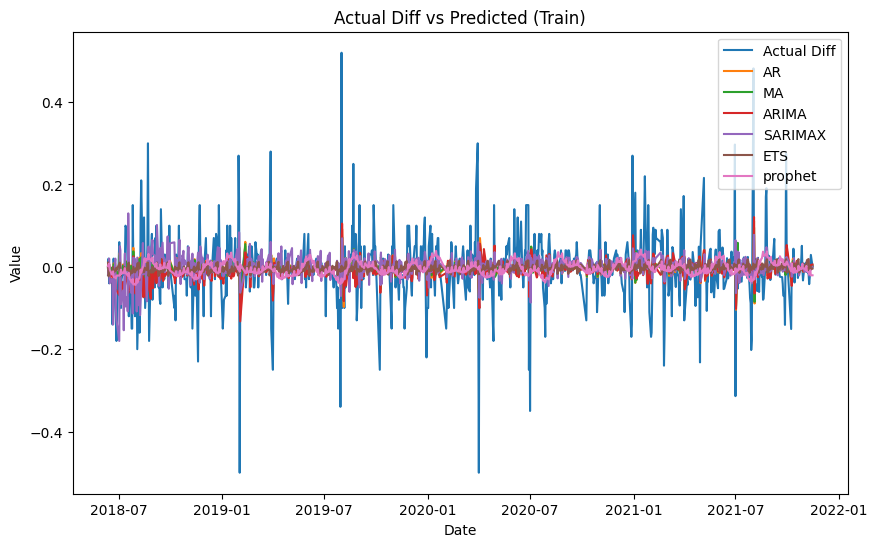

In [74]:
plt.figure(figsize=(10, 6))
# Plot the actual test values
plt.plot(train_df['ds'], train_df['y'], label='Actual Diff')
# Plot ar predicted values
plt.plot(train_df['ds'][2:], diff_ar_train_predictions.values, label='AR')
# Plot ma predicted values
plt.plot(train_df['ds'], diff_ma_train_predictions.values, label='MA')
# Plot arima predicted values
plt.plot(train_df['ds'], diff_arima_train_predictions.values, label='ARIMA')
# Plot SARIMAX predicted values
plt.plot(train_df['ds'], diff_sarimax_train_predictions.values, label='SARIMAX')
# Plot ETS predicted values
plt.plot(train_df['ds'], diff_ets_train_predictions.values, label='ETS')
# Plot the prophet predicted values
plt.plot(train_df['ds'], prophet_train_forecast['yhat'], label='prophet')

plt.legend(loc='upper right')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Diff vs Predicted (Train)')
plt.show()

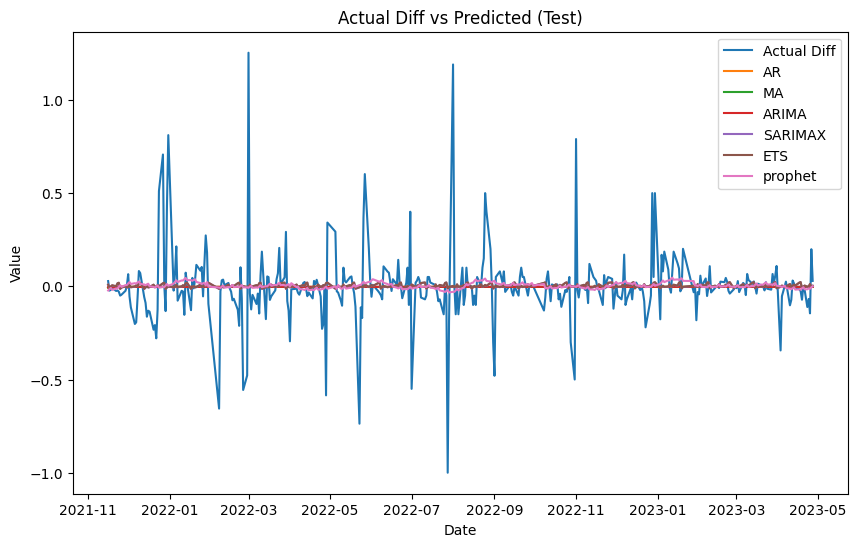

In [77]:
plt.figure(figsize=(10, 6))
# Plot the actual test values
plt.plot(test_df['ds'], test_df['y'], label='Actual Diff')
# Plot ar predicted values
plt.plot(test_df['ds'], diff_ar_forecast.values, label='AR')
# Plot ma predicted values
plt.plot(test_df['ds'], diff_ma_forecast.values, label='MA')
# Plot arima predicted values
plt.plot(test_df['ds'], diff_arima_forecast.values, label='ARIMA')
# Plot SARIMAX predicted values
plt.plot(test_df['ds'], sarimax_forecast.values, label='SARIMAX')
# Plot ETS predicted values
plt.plot(test_df['ds'], diff_ets_forecast.values, label='ETS')
# Plot the prophet predicted values
plt.plot(test_df['ds'], diff_prophet_forecast['yhat'], label='prophet')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Diff vs Predicted (Test)')
plt.show()

In [ ]:
model_names = ['AR_Diff', 'MA_Diff', 'ARIMA_Diff', 'SARIMAX_Diff', 'ETS_Diff', 'Prophet_Diff']
rmses = [diff_ar_rmse, diff_ma_rmse, diff_arima_rmse, sarimax_rmse, diff_ets_rmse, diff_prophet_rmse]

comparison_df = pd.DataFrame({'Model': model_names, 'RMSE': rmses})
print(comparison_df)


          Model      RMSE
0       AR_Diff  0.192017
1       MA_Diff  0.192018
2    ARIMA_Diff  0.192013
3  SARIMAX_Diff  0.191599
4      ETS_Diff  0.191598
5  Prophet_Diff  0.191238


# LSTM

## Preprocessing 数据预处理

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

# Load the data
data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/微众实习/Shibor_LPR_国债相关利率数据.xlsx')
data.set_index('日期', inplace=True)

# 删除'市场询价利率(6M)'缺失值
data.dropna(subset=['市场询价利率(6M)'], inplace=True)

In [ ]:
# Separate features and target variable (last column)
features = data.iloc[:, :-1]
target = data.iloc[:, -1]

# Scaling the features and target separately
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

scaled_data = np.concatenate([scaled_features, scaled_target], axis=1)

# Splitting the data
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]

# Creating sequences using TimeseriesGenerator
# 用TimeseriesGenerator创建时间序列
look_back = 10
#look_back = 10 days之前的历史数据: Test RMSE for LSTM model: 0.5957
#look_back = 5 days之前的历史数据: Test RMSE for LSTM model: 1.2707
n_features = data.shape[1]
generator = TimeseriesGenerator(train, train[:, -1], length=look_back, batch_size=6)
validation_generator = TimeseriesGenerator(test, test[:, -1], length=look_back, batch_size=6)

## Creating the Model 创建模型

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
# Create the Sequential model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

## Training and Prediction

In [ ]:
model.fit(generator, epochs=200, validation_data=validation_generator)

Epoch 1/200
160/160 [==============================] - 3s 9ms/step - loss: 0.0308 - val_loss: 0.0069
Epoch 2/200
160/160 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0069
Epoch 3/200
160/160 [==============================] - 1s 5ms/step - loss: 0.0053 - val_loss: 0.0072
Epoch 4/200
160/160 [==============================] - 1s 7ms/step - loss: 0.0048 - val_loss: 0.0060
Epoch 5/200
160/160 [==============================] - 1s 4ms/step - loss: 0.0037 - val_loss: 0.0057
Epoch 6/200
160/160 [==============================] - 1s 4ms/step - loss: 0.0037 - val_loss: 0.0058
Epoch 7/200
160/160 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 8/200
160/160 [==============================] - 1s 4ms/step - loss: 0.0022 - val_loss: 0.0040
Epoch 9/200
160/160 [==============================] - 1s 4ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 10/200
160/160 [==============================] - 1s 4ms/step - loss: 0.0020 - val_lo

In [ ]:
# Make predictions
predictions_scaled = []
batch = train[-look_back:]
current_batch = train[-look_back:].reshape((1, look_back, n_features))


In [ ]:
# Making predictions
for i in range(len(test)):
    pred = model.predict(current_batch)[0]
    predictions_scaled.append(pred)

    # Create a placeholder for the next batch
    next_batch = np.zeros((1, look_back, n_features))
    next_batch[:, :-1, :-1] = current_batch[:, 1:, :-1]
    next_batch[:, -1, :-1] = 0
    next_batch[:, -1, -1] = pred
    current_batch = next_batch

# Inverse scaling for predictions
predictions = scaler_target.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))


1/1 [==============================] - 0s 22ms/step


In [ ]:
# Generate predictions on the test data
predictions = model.predict(validation_generator)

# Rescale the predictions
predictions_rescaled = scaler_target.inverse_transform(predictions)

# Rescale the actual values
actuals_rescaled = scaler_target.inverse_transform(test_target[look_back:])

# Compare using RMSE
rmse = sqrt(mean_squared_error(actuals_rescaled, predictions_rescaled))
print('Test RMSE:', rmse) #Test RMSE: 0.015390314252425518


## RMSE

In [ ]:
# Extract actual values
actuals = data.iloc[train_size + look_back:, -1].values

# Ensure predictions and actuals have the same shape
predictions_resized = predictions[:len(actuals), 0]

# Calculate error and RMSE
error = actuals - predictions_resized
rmse = np.sqrt(np.mean(error**2))

print(f'Test RMSE for LSTM model:, {rmse:.4f}')

Test RMSE for LSTM model:, 1.4606


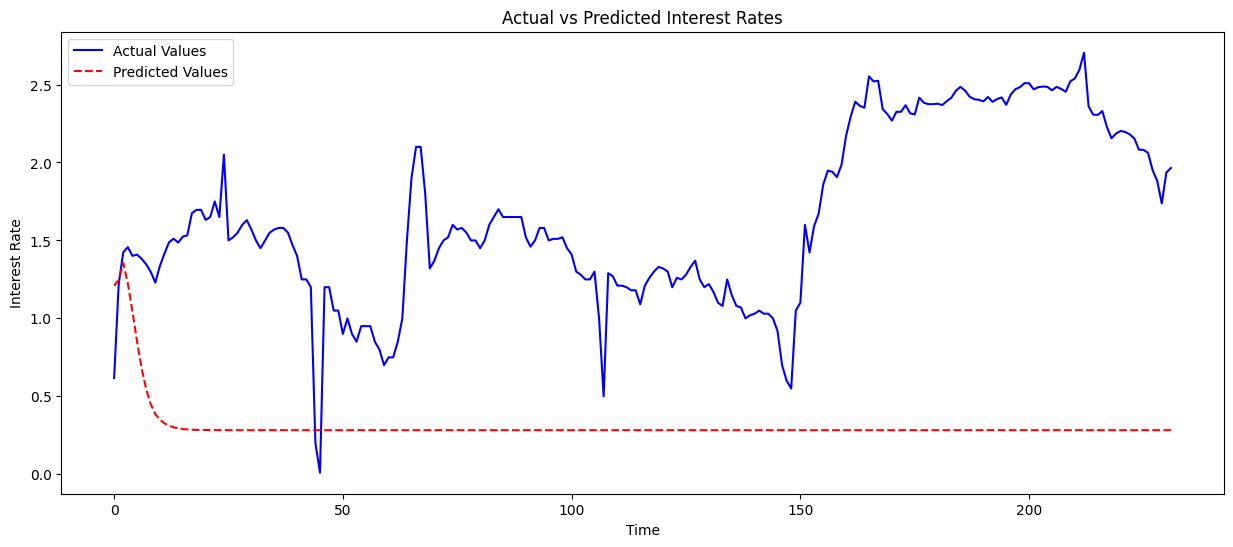

In [ ]:
# Plotting the actual values
plt.figure(figsize=(15, 6))
plt.plot(actuals, label='Actual Values', color='blue')

# Plotting the predicted values
plt.plot(predictions_resized, label='Predicted Values', color='red', linestyle='dashed')

plt.title('Actual vs Predicted Interest Rates')
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.legend()
plt.show()


## Transforming data



In [ ]:
df_trans = data.copy()

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose


# Generate lag features
# 生成滞后特征，将过去1到3个时间步的数据作为新的特征
for lag in range(1, 4):
    df_trans[f'lag_{lag}'] = df_trans['市场询价利率(6M)'].shift(lag)

# Rolling window statistics
# 单位长度为3个时间步的滑动窗口，将滑块内的均值作为新的特征
df_trans['rolling_mean_3'] = df_trans['市场询价利率(6M)'].rolling(window=3).mean()

# Exponential Moving Average
# 指数移动平均
df_trans['ema_3'] = df_trans['市场询价利率(6M)'].ewm(span=3).mean()

# Seasonal Decomposition
# 季节性分解
result = seasonal_decompose(df_trans['市场询价利率(6M)'], model='additive', period=3)
df_trans['trend'] = result.trend
df_trans['seasonal'] = result.seasonal

# Drop any NaN values
df_trans.dropna(inplace=True)


In [ ]:
df_trans.columns

Index(['O/N', '1W', '2W', '1M', '3M', '6M', '9M', '1Y', 'LPR(1Y)', '1年期国债收益率',
       '10年期国债收益率', '市场询价利率(6M)', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3',
       'ema_3', 'trend', 'seasonal'],
      dtype='object')

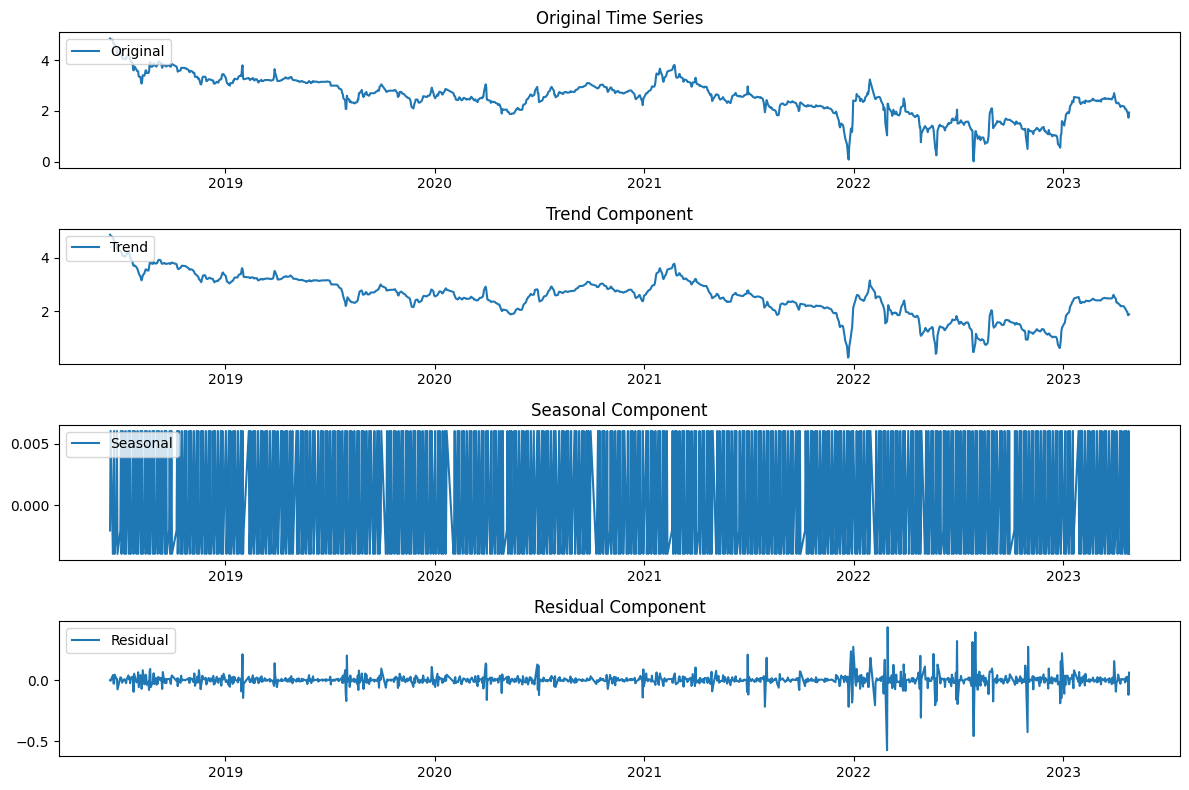

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Original Series
plt.subplot(4, 1, 1)
plt.plot(df_trans['市场询价利率(6M)'], label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Trend
plt.subplot(4, 1, 2)
plt.plot(df_trans['trend'], label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

# Seasonal
plt.subplot(4, 1, 3)
plt.plot(df_trans['seasonal'], label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Residuals
plt.subplot(4, 1, 4)
residual = df_trans['市场询价利率(6M)'] - df_trans['trend'] - df_trans['seasonal']
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Separate features and target
X = df_trans.drop(columns=['市场询价利率(6M)'])
y = df_trans['市场询价利率(6M)']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit a random forest regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# Pair with feature names and sort
feature_importance_pairs = sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in feature_importance_pairs:
    print(f"{feature}: {importance}")

trend: 0.6150788663070226
ema_3: 0.36260805911416466
rolling_mean_3: 0.007144942763829334
lag_1: 0.0033999467010776764
3M: 0.0015640579762950231
9M: 0.001500509470581031
1M: 0.0014816134419836462
1Y: 0.0014691015997995182
lag_2: 0.0012397666276770605
lag_3: 0.0010506446699327424
6M: 0.001013737224176878
O/N: 0.0005823955902330334
1年期国债收益率: 0.000509955562530084
10年期国债收益率: 0.0005061647280161204
1W: 0.00033757431876839486
2W: 0.0003204714707013177
seasonal: 0.00012576863164078035
LPR(1Y): 6.642380157026773e-05


In [ ]:
# Selecting the top N features
N = 5
selected_features = [feature for feature, _ in feature_importance_pairs[:N]]

# Separate features and target variable (last column)
features = df_trans[selected_features]  # Selecting only the top N features
target = df_trans['市场询价利率(6M)']

# Scaling the features and target separately
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

scaled_data = np.concatenate([scaled_features, scaled_target], axis=1)

# Splitting the data
train_size = int(len(scaled_data) * 0.8)
train_features, test_features = scaled_features[:train_size], scaled_features[train_size:]
train_target, test_target = scaled_target[:train_size], scaled_target[train_size:]

look_back = 5
batch_size = 6

generator = TimeseriesGenerator(train_features, train_target, length=look_back, batch_size=batch_size)
validation_generator = TimeseriesGenerator(test_features, test_target, length=look_back, batch_size=batch_size)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
# Create the Sequential model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, N)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(generator, epochs=200, validation_data=validation_generator)

Epoch 1/200
160/160 [==============================] - 2s 4ms/step - loss: 0.0202 - val_loss: 0.0031
Epoch 2/200
160/160 [==============================] - 1s 4ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 3/200
160/160 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 4/200
160/160 [==============================] - 1s 4ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 5/200
160/160 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 6/200
160/160 [==============================] - 1s 4ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 7/200
160/160 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 8/200
160/160 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 9/200
160/160 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 10/200
160/160 [==============================] - 1s 3ms/step - loss: 0.0013 - val_lo

In [ ]:
# Make predictions
predictions_scaled = []
batch = train[-look_back:]
current_batch = train[-look_back:].reshape((1, look_back, n_features))
# Making predictions
for i in range(len(test)):
    pred = model.predict(current_batch)[0]
    predictions_scaled.append(pred)

    # Create a placeholder for the next batch
    next_batch = np.zeros((1, look_back, n_features))
    next_batch[:, :-1, :-1] = current_batch[:, 1:, :-1]
    next_batch[:, -1, :-1] = 0
    next_batch[:, -1, -1] = pred
    current_batch = next_batch

# Inverse scaling for predictions
predictions = scaler_target.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))


In [ ]:
# Generate predictions on the test data
predictions = model.predict(validation_generator)

# Rescale the predictions
predictions_rescaled = scaler_target.inverse_transform(predictions)

# Rescale the actual values
actuals_rescaled = scaler_target.inverse_transform(test_target[look_back:])

# Compare using RMSE
rmse = sqrt(mean_squared_error(actuals_rescaled, predictions_rescaled))
print('Test RMSE:', rmse) #Test RMSE: 0.015390314252425518


40/40 [==============================] - 0s 1ms/step
Test RMSE: 0.016665449103438038


In [ ]:
print("Actuals:", actuals_rescaled[:10])
print("Predictions:", predictions_rescaled[:10])


Actuals: [[1.416]
 [1.414]
 [1.378]
 [1.269]
 [0.532]
 [0.419]
 [0.249]
 [0.617]
 [1.219]
 [1.424]]
Predictions: [[1.414401  ]
 [1.4123703 ]
 [1.378058  ]
 [1.2723665 ]
 [0.57907677]
 [0.4519092 ]
 [0.2592112 ]
 [0.5864383 ]
 [1.2141984 ]
 [1.4112537 ]]


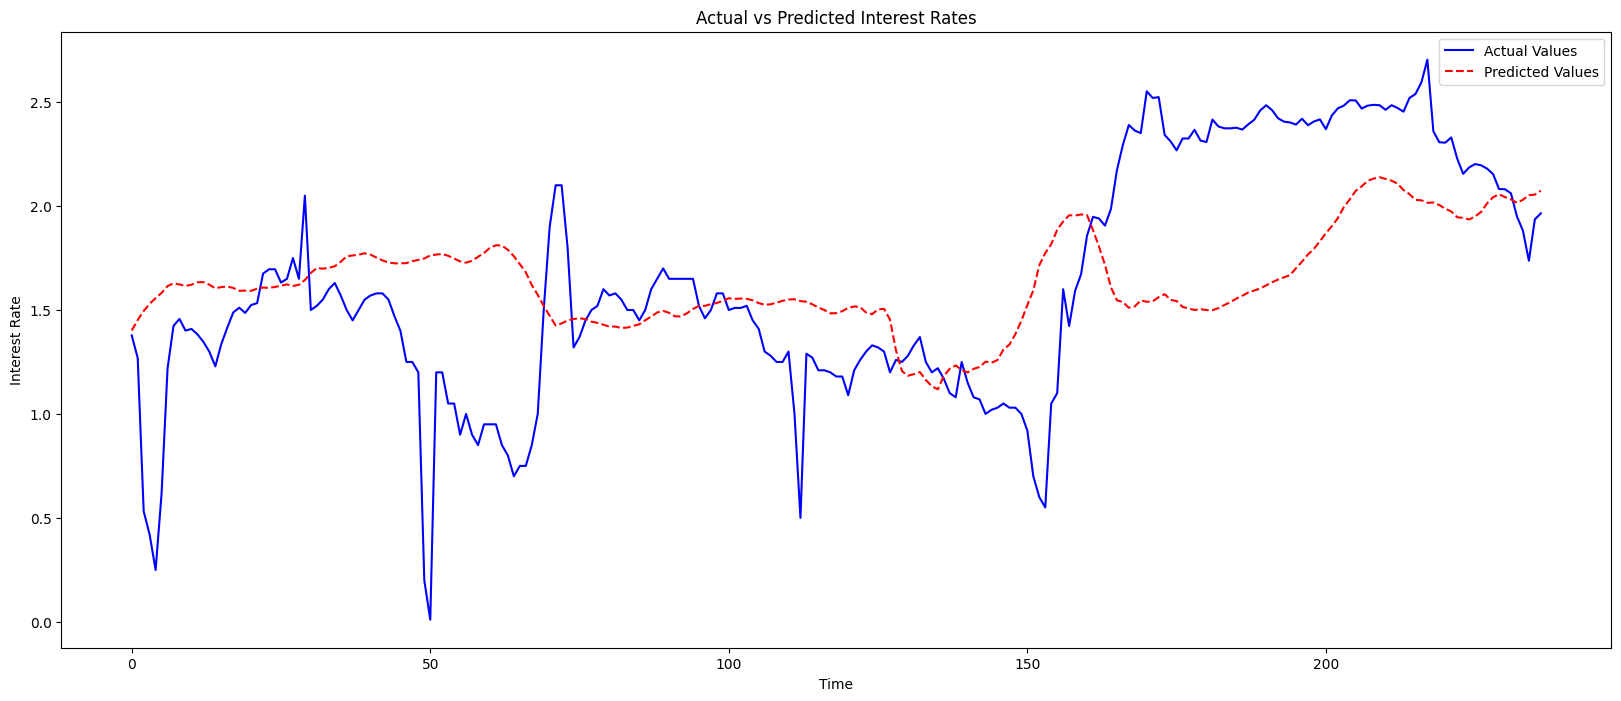

In [ ]:
# Plotting the actual values
plt.figure(figsize=(20, 8))
plt.plot(actuals_rescaled, label='Actual Values', color='blue')

# Plotting the predicted values
plt.plot(predictions_rescaled, label='Predicted Values', color='red', linestyle='dashed')

plt.title('Actual vs Predicted Interest Rates')
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.legend()
plt.show()


In [ ]:
df_trans = data.copy()

In [ ]:
train_size = int(len(df_trans) * 0.8)
train, test = df_trans.iloc[:train_size].copy(), df_trans.iloc[train_size:].copy()


In [ ]:
# For the train set
for lag in range(1, 4):
    train[f'lag_{lag}'] = train['市场询价利率(6M)'].shift(lag)

train['rolling_mean_3'] = train['市场询价利率(6M)'].rolling(window=3).mean()
train['ema_3'] = train['市场询价利率(6M)'].ewm(span=3).mean()

result_train = seasonal_decompose(train['市场询价利率(6M)'], model='additive', period=3)
train['trend'] = result_train.trend
train['seasonal'] = result_train.seasonal

train.dropna(inplace=True)

In [ ]:
# Assuming you have a way to compute feature_importance_pairs for the train dataset
features_train = train[selected_features]
target_train = train['市场询价利率(6M)']

In [ ]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

scaled_features_train = scaler_features.fit_transform(features_train)
scaled_target_train = scaler_target.fit_transform(target_train.values.reshape(-1, 1))

In [ ]:
look_back = 5
batch_size = 6

generator = TimeseriesGenerator(scaled_features_train, scaled_target_train, length=look_back, batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, N)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# For the test set
for lag in range(1, 4):
    test[f'lag_{lag}'] = test['市场询价利率(6M)'].shift(lag)

test['rolling_mean_3'] = test['市场询价利率(6M)'].rolling(window=3).mean()
test['ema_3'] = test['市场询价利率(6M)'].ewm(span=3).mean()

result_test = seasonal_decompose(test['市场询价利率(6M)'], model='additive', period=3)
test['trend'] = result_test.trend
test['seasonal'] = result_test.seasonal
test.dropna(inplace=True)

scaled_features_test = scaler_features.transform(test[selected_features])
scaled_target_test = scaler_target.transform(test['市场询价利率(6M)'].values.reshape(-1, 1))

validation_generator = TimeseriesGenerator(scaled_features_test, scaled_target_test, length=look_back, batch_size=batch_size)
model.fit(generator, epochs=200, validation_data=validation_generator)

In [ ]:
# Generate predictions on the test data
predictions = model.predict(validation_generator)

# Rescale the predictions
predictions_rescaled = scaler_target.inverse_transform(predictions)

# Rescale the actual values
actuals_rescaled = scaler_target.inverse_transform(scaled_target_test[look_back:])

# Compare using RMSE
rmse = sqrt(mean_squared_error(actuals_rescaled, predictions_rescaled))
print('Test RMSE:', rmse) #Test RMSE: 0.015390314252425518


39/39 [==============================] - 1s 1ms/step
Test RMSE: 0.010046324861449636
